# Problem 1: Estimate Crowd Size on Bridge

#### For this problem, what we want is estimating the number of people present on the bridge during the time frame 0:14 to 0:32 of the video, 
#### there several steps to approach this problem: data collection, data preprocessing, model selection, generating results, results visualization and validation. 
#### I first download the vedio from Youtube, then split it into several images, and detecting the number of people in each image. 
#### From the images, we can see that the size of people is too small, which is impossible for any neural networks to detect people from it. 
#### The best way is to split each image into small pieces, and put them into model instead. After genearting results from each image, what I do is simpliy taking the average of all images. 

# Install the package

In [1]:
!pip install yt-dlp

# Download and Rename the Youtube vedio

In [4]:
!yt-dlp -o 'vedio' https://www.youtube.com/watch?v=y2zyucfCyjM

[youtube] Extracting URL: https://www.youtube.com/watch?v=y2zyucfCyjM
[youtube] y2zyucfCyjM: Downloading webpage
[youtube] y2zyucfCyjM: Downloading ios player API JSON
[youtube] y2zyucfCyjM: Downloading web creator player API JSON
[youtube] y2zyucfCyjM: Downloading m3u8 information
[info] y2zyucfCyjM: Downloading 1 format(s): 137+251
[download] Destination: vedio.mp4.f137.mp4
[download] 100% of   62.28MiB in 00:01:31 at 700.08KiB/s33m00:000m
[download] Destination: vedio.mp4.f251.webm
[download] 100% of    2.03MiB in 00:00:03 at 671.59KiB/s33m00:00
[Merger] Merging formats into "vedio.mp4.mkv"
Deleting original file vedio.mp4.f137.mp4 (pass -k to keep)
Deleting original file vedio.mp4.f251.webm (pass -k to keep)


# Select device to run the neural networks

In [14]:
import os
import torch 
from torch.utils.data import DataLoader
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using GPU


# Ignore warnings for code implementation

In [2]:
import warnings
# ignore warning scripts
warnings.filterwarnings('ignore') 

In [3]:
%matplotlib inline

# Collect images from vedio and make it to be the input of the model

In [4]:
import cv2
from tqdm import tqdm
# Open video and set parameters
video_path = 'vedio.mkv'  # Assume video is downloaded
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
start_time = 14  # seconds
end_time = 32    # seconds

start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

frames = []
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Extract every 5th frame
frame_num = start_frame
while frame_num <= end_frame:
    ret, frame = cap.read()
    if not ret:
        break
    if frame_num % 5 == 0:
        frames.append(frame)
    frame_num += 1

cap.release()


# Data preprocess

image shape (1080, 1920, 3)


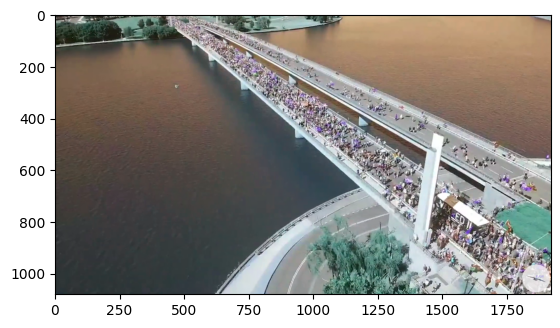

In [5]:
# In this case we want to load torchvision model to detect the people on the image. To improve the accuracy, we need to split each image 
# into small pieces, manually find the most approporate size of sub images.
import matplotlib.pyplot as plt
import numpy as np
# load the first image
img1 = frames[80]
print('image shape',img1.shape)
# visualize the image
plt.imshow(img1)

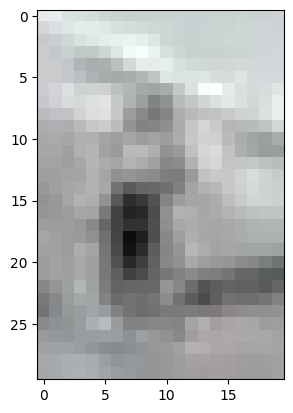

In [6]:
# find sub-image size to cover single person, make the image size can be divided by large image 
# generate a sample for visualization
one_person = img1[330:360,1270:1290]
test_frame = [one_person]
plt.imshow(test_frame[0])

In [7]:
# cut the image into small pieces, we split 91 images with size 1080x1920 into 91x3456 sub images with size 20x30
new_frame = []
for frame in tqdm(frames):
    tmp = []
    x_size = frame.shape[0]
    y_size = frame.shape[1]
    for i in range(x_size//20):
        for j in range(y_size//30):
            tmp.append(frame[i*20:(i+1)*20,j*30:(j+1)*30])
    new_frame.append(np.stack(tmp))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 132.67it/s]


In [8]:
new_frame[0].shape

(3456, 20, 30, 3)

# Load the model from torchvision
#### There are several models to select for CV: 
## 1. YOLOv5 
#### Model: ultralytics/yolov5
#### Best for: Real-time object detection, including people detection. 
#### Pros: Very fast and accurate, works well on both CPU and GPU, supports bounding box detection. 
#### Cons: Can be overkill for simpler tasks if real-time performance is not required.
## 2. Faster R-CNN
#### Model: facebookresearch/detectron2
#### Best for: General-purpose object detection with a focus on accuracy.
#### Pros: Very accurate and widely used in academic and industry settings for tasks requiring high precision.
#### Cons: Slower than YOLOv5, especially for real-time applications.
## 3. Mask R-CNN
#### Model: facebookresearch/detectron2
#### Best for: Instance segmentation, detecting people, and generating masks for each person.
#### Pros: Best for tasks where you need pixel-wise segmentation of people (i.e., detecting exact outlines, not just bounding boxes).
#### Cons: Slower than YOLOv5, more computationally expensive
## 4. RetinaNet
#### Model: facebookresearch/detectron2
#### Best for: Object detection with a good balance of speed and accuracy.
#### Pros: Performs well on both large and small objects, offers a good balance between Faster R-CNN and YOLOv5 in terms of speed and accuracy.
#### Cons: Slightly slower than YOLOv5, but faster than Faster R-CNN.

## In this case, since the person size is extremely small compared with the image size, which could be a challenge for model to detect. I would take precision over efficiency, therefore, I select the mask r-cnn model

In [9]:
# load the model and have a test
import torchvision

# Load the Mask R-CNN model, which has great perfromance on CV, especially for detecting such as person.
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

# Write functions to detect people from each image
### 1: Function for generating predicted results by Mask R-CNN model (for each set of sub images)

In [88]:
# function to predict people for each sub-image
def detect_people(device,
                  model,
                  frames,
                  batch_size = 64
                 ):
    """
    device: device to run the model
    model: model architecture to use
    frame: list of images

    retrun: list of results
    """
    # put model to device
    model.to(device)
    # predict results
    results = []
    for frame in tqdm(frames, leave=True):
        with torch.no_grad():
            if len(frame.shape)==3:
                tensor = torch.from_numpy(frame).unsqueeze(0).permute(0,3,1,2)
            else:
                tensor = torch.from_numpy(frame).permute(0,3,1,2)
            # Ensure the tensor is in the correct shape and format (float32)
            tensor = tensor.float()
            # transfer data into dataloader for batch training
            dataloader = DataLoader(
                tensor, batch_size=batch_size, shuffle=True, num_workers=0
            )
            for x in tqdm(dataloader):
                x.to(device)
#                print(x.shape)
                result = model(x.to(device))  # Get predictions
                results.append(result)
    return results

## 2: Function for extracting person numbers from the return value of function 1

In [86]:
# function to calculate the number of people from the results generated by detect_people function
def calculate(res,
              threshold=0.5
             ):
    """
    res: the results from detect_people
    threshold: the probability the people detected in image 

    return: number of people
    """
    count = 0
    m = len(res)
    for i in range(m):
        for j in range(len(res[i])):
            if 1 in res[i][j]['labels']:
                # find the index where label =1, which means person detected
                index = np.argwhere(res[i][j]['labels'].cpu()==1)
                # count the image where probability of person
                count+=torch.sum(res[i][j]['scores'][index]>threshold)
    return count

# Calculate the people in each image and estimated average number of people

In [91]:
person_counts = []
for i in range(len(new_frame)):
    results = detect_people(device,
                              model,
                              [new_frame[i]],
                              batch_size = 64)
    person_counts.append(calculate(results).cpu())
# Estimate the average count over the frames
average_people = sum(person_counts) / len(person_counts)
print(f'Estimated average number of people: {average_people}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:24<00:00, 84.02s/it]


Estimated average number of people: 817.2088012695312


#### If we go back and watch the vedio, we can easily find that there are mainly two seperated regions from 14 sec to 32 sec: Off the Bridge
#### and On the Bridge, we can assume the number of total people approximatly equal to $ average people \times 2$, since each image can 
#### cover approximately half of the total regions.

In [95]:
print(f'Estimated average number of people: {2*average_people}')

Estimated average number of people: 1634.4176025390625
